In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import string

standingsDF = pd.read_csv('driver_standings.csv')
lapTimesDF = pd.read_csv('lap_times.csv')
resultsDF = pd.read_csv('results.csv')

resultsDF.shape

(25660, 18)

We see that we have a very comprehensive dataset. We have 18 columns, and 25660 rows/entries.

In [4]:
resultsDF.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

Quantitative Discrete:
resultId, raceId, driverId, constructorId, number, grid, points, laps, milliseconds, fastestLap

Quantitative Continuous:
time, fastestLapTime, fastestLapSpeed

Categorical Nominal:
none

Categorical Ordinal:
position, positionText, positionOrder, rank

Some interesting pieces of data are the position and positionText columns. Position indicates the final position of a driver at that specific race. However, we know that some drivers don't necessarily finish every race, due to a number of issues. To circumnavigate this, we could use the positionOrder column, which indicates the final rank of a driver at a specific race. This allows us to collect data on final finishing positions without having to take DNF's into account.

Although we're able to bypass DNF's for the final finishing positions, the same can't be said for other data collected from that driver that race. For example, what happens when a driver can't complete a lap before they retire? We won't have that driver's fastestLapTime, fastestLapSpeed, and rank values. 

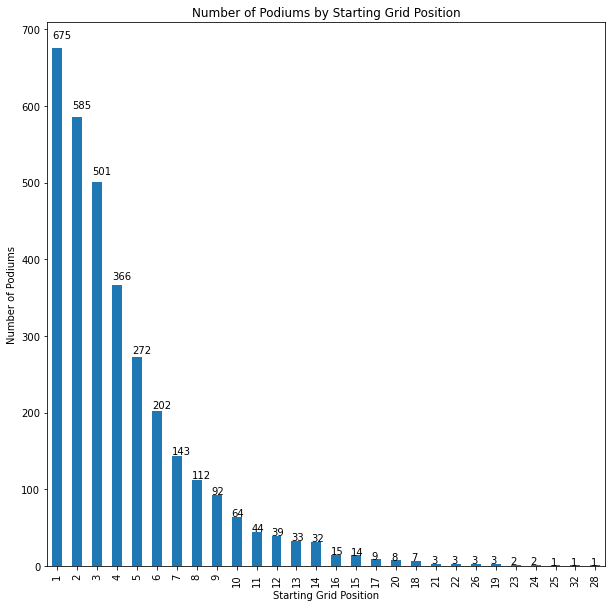

In [34]:
podiumDF = resultsDF[['positionOrder', 'grid']]
podiumDF = podiumDF.loc[podiumDF['positionOrder'] <= 3]

podiumGraph = podiumDF['grid'].value_counts().plot.bar(figsize = (10, 10), title = 'Number of Podiums by Starting Grid Position')
podiumGraph.set_xlabel('Starting Grid Position')
podiumGraph.set_ylabel('Number of Podiums')

for label in podiumGraph.patches:
    podiumGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

As we can see from the following visualization, out of 3,232 podium results, 1,761, or 54.49% were achieved from drivers who qualified in the top 3 positions. This indicates that qualifying top 3 is a large advantage in the final race.

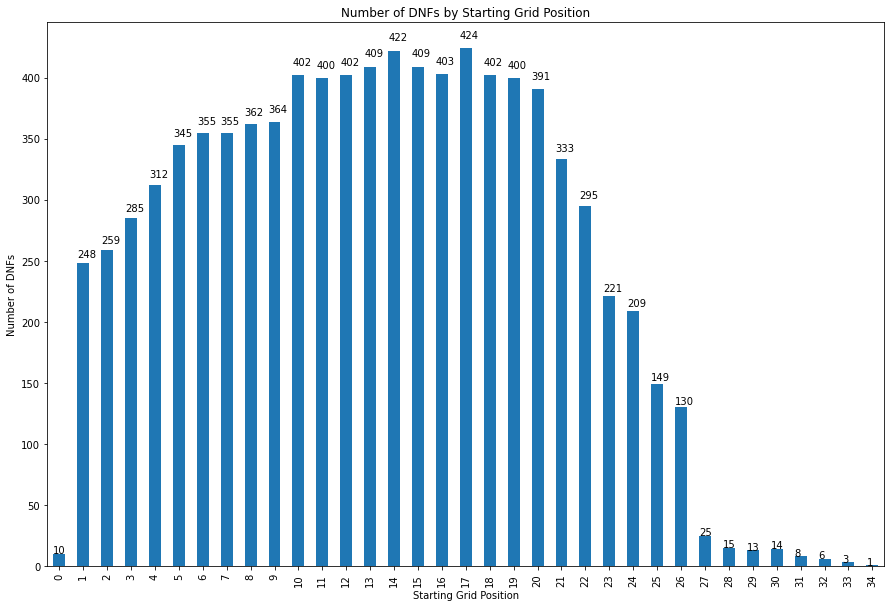

In [41]:
dnfDF = resultsDF[['grid', 'positionText']]
dnfDF = dnfDF.loc[dnfDF['positionText'] == 'R']

dnfGraph = dnfDF['grid'].value_counts().sort_index().plot.bar(figsize = (15, 10), title = 'Number of DNFs by Starting Grid Position',)
dnfGraph.set_xlabel('Starting Grid Position')
dnfGraph.set_ylabel('Number of DNFs')

for label in dnfGraph.patches:
    dnfGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

This visualization shows an interesting trend. The top 11 grid positions in terms of number of DNFs are all in the bottom half of the possible starting grid positions. Additionally, these 11 grid positions account for 4464 total DNFs out of the 8781 overall DNFs. In other words, around 51% of DNFs came from drivers who started in these grid positions. This raises the question of why so many DNFs come from those starting grid positions. Are drivers further in the back of the pack more likely to get into crashes? Do these drivers push their cars harder to make up for their poor qualifying performances? 

In [7]:
# Helper function to add DNF column
def DNFHelper(row):
    if row['positionText_x'] == 0:
        DNF = 1
    else:
        DNF = 0
    
    return DNF
    

helperDF = resultsDF

# Replaces all of our DNFs to 0 to be used in our linear regression
helperDF = pd.merge(helperDF, standingsDF, on = ['driverId', 'raceId'])
helperDF = helperDF.replace(to_replace=['R', 'D', 'E', 'W', 'F', 'N'], value= 0, regex = True)

# DNF that holds all of our values except positionText 

# Adding the DNF column to our dataframe
helperDF['DNF'] = helperDF.apply(DNFHelper, axis = 1)

allDF = helperDF.loc[:, helperDF.columns != 'positionText']

allDF = allDF.drop(['positionOrder'], axis = 1)
allDF = allDF.drop(['position_x'], axis = 1)
allDF = allDF.drop(['position_y'], axis = 1)
allDF = allDF.drop(['laps'], axis = 1)
allDF = allDF.drop(['positionText_x'], axis = 1)
allDF = allDF.drop(['positionText_y'], axis = 1)
allDF = allDF.drop(['points_x'], axis = 1)
allDF = allDF.drop(['statusId'], axis = 1)
allDF = allDF.drop(['time'], axis = 1)

allDF['fastestLapTime'] = allDF['fastestLapTime'].str.replace('[^\w\s]','')
allDF['fastestLapSpeed'] = allDF['fastestLapSpeed'].str.replace('[^\w\s]','')

allDF = allDF.fillna(0)

print(allDF)

xTrain, xTest, yTrain, yTest = train_test_split(allDF, helperDF.DNF, test_size = 0.2)

dnfRegression = LinearRegression()

rfe = RFE(estimator = dnfRegression, n_features_to_select = 4, step = 1)
rfe.fit(xTrain, yTrain)
# grid, rank, and wins are the top 3 features
print(rfe.support_)
print(rfe.ranking_)

topThreeFeats = helperDF[['rank', 'laps', 'grid']]

topXTrain, topXTest, topYTrain, topYTest = train_test_split(topThreeFeats, helperDF.DNF, test_size = 0.2)

rfeRegression = LinearRegression()

rfeRegression.fit(topXTrain, topYTrain)

rfeYPred = rfeRegression.predict(topXTest)
rfeYTrainPred = rfeRegression.predict(topXTrain)

print('Intercept: ', rfeRegression.intercept_)

# TODO: print the r-squared
print('r-squared: %.2f' % r2_score(topYTest, rfeYPred))

# TODO: print the mean squared error for training
print('for training: %.2f' % mean_squared_error(topYTrain, rfeYTrainPred))

# TODO: print the mean squared error for testing
print('for testing: %.2f' % mean_squared_error(topYTest, rfeYPred))

       resultId  raceId  driverId  constructorId number  grid milliseconds  \
0             1      18         1              1     22     1      5690616   
1             2      18         2              2      3     5      5696094   
2             3      18         3              3      7     7      5698779   
3             4      18         4              4      5    11      5707797   
4             5      18         5              1     23     3      5708630   
...         ...     ...       ...            ...    ...   ...          ...   
25186     25661    1086       825            210     20    13            0   
25187     25662    1086       848              3     23    17            0   
25188     25663    1086       849              3      6    19            0   
25189     25664    1086       852            213     22    16            0   
25190     25665    1086       822             51     77     8            0   

      fastestLap rank fastestLapTime fastestLapSpeed  driverSta

Before running our Linear Regression, we had to prune some of the columns off of our dataframe. Particularly, we got rid of the positionOrder, position_x, position_y, laps, positionText_x, positionText_y, points_x, and statusId. We had to get rid of these columns because they wouldn't be able to be used to predict a future DNF. Since these columns refer data collected AFTER the race, it's not much use for the task that we're looking to accomplish. We also had many missing fastestLapTimes and fastestLapSpeeds, so we filled in the NaN values with 0.

As we can see, our RFE selects the top 3 features to predict whether or not a DNF will happen. The 3 features the RFE picked were grid, rank, and wins. Grid refers to the starting grid position, rank refers to the ranking of the driver's fastest lap, and wins refers to the number of wins that driver has that season.

Our intercept is 0.89, meaning that if a driver starts from the pitlane, has the fastest lap time, and has no wins, they're very likely to DNF. Furthermore, our r-squared value is 0.48, meaning that the relationship between our regression and DNFs is around 48%. This means our model isn't the greatest fit for our data. Our Mean Squared Error values for both training and testing are around 0.12, meaning that we have a very low rate of error in prediction. This tells us that the three features the RFE picked are very effective in predicting a future DNF. 